In [1]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

2023-07-19 20:17:36.721928: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-19 20:17:36.749526: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-19 20:17:36.750263: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-19 20:17:37.444491: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
df = pd.read_csv("./cleaned_metadata.csv")
df.head()

,Unnamed: 0,image_url,label,md5
0,0,d6540236-5774-4375-8aad-53582b98bb32.jpeg,0,6191699ae559665d149117051c5a0889
1,1,db9f7f97-83ff-4629-af51-1710066d3b13.jpeg,0,43e57e275b11a4b5598a2b45bfceee5f
2,2,4243da34-6908-4296-95d2-e4d741e63c65.jpeg,1,659381b23d687bfb3a0f94073a4bb10a
3,3,44b0a168-495d-4579-a0f5-7832bf1f29ff.webp,0,04d80553a297a036ce6b90b83b5a5a56
4,4,7e1ffa0f-c6c1-44db-8f7d-32a5e58aaeed.jpeg,0,2b186584a1f668972a1b760312263be1


In [3]:
positives = df.query("label == 1")[:200]
negatives = df.query("label == 0")[:200]
df = pd.concat((positives, negatives))

In [4]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df.label)
train_df, val_df = train_test_split(train_df, test_size=0.1, stratify=train_df.label)

# positives = train_df.query("label == 1")
# negatives = train_df.query("label == 0")

# for _ in range(int(len(negatives) / len(positives))):
#     train_df = pd.concat((train_df, positives))

print(train_df.label.value_counts(normalize=True))
print(val_df.label.value_counts(normalize=True))
print(test_df.label.value_counts(normalize=True))

label
0    0.527473
1    0.472527
Name: proportion, dtype: float64
label
0    0.516129
1    0.483871
Name: proportion, dtype: float64
label
0    0.519481
1    0.480519
Name: proportion, dtype: float64


In [5]:
DATASET_PATH = "./data-collector/data/md5"
BATCH_SIZE = 8
BUFFER_SIZE = 1500
IMAGE_SIZE = (128, 128)

In [6]:
def load_image(image_path: str, label: int):
    image = tf.io.read_file(DATASET_PATH + "/" + image_path + ".jpg")
    image = tf.image.decode_image(image)
    image /= 0xff
    image = tf.image.resize_with_pad(image, target_height=IMAGE_SIZE[0], target_width=IMAGE_SIZE[1])
    return image, label

def augmentation(image, label):
    image = tf.image.random_flip_left_right(image)
    # image = tf.image.random_contrast(image, lower=0.2, upper=0.5)
    return image, label

In [73]:
train_ds = tf.data.Dataset.from_tensor_slices((train_df.md5, train_df.label)).map(load_image).batch(BATCH_SIZE).shuffle(BUFFER_SIZE)
val_ds = tf.data.Dataset.from_tensor_slices((val_df.md5, val_df.label)).map(load_image).batch(BATCH_SIZE).shuffle(BUFFER_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((test_df.md5, test_df.label)).map(load_image).batch(BATCH_SIZE).shuffle(BUFFER_SIZE)

2023-07-19 20:33:24.278680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [273]
	 [[{{node Placeholder/_1}}]]
2023-07-19 20:33:24.278885: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [273]
	 [[{{node Placeholder/_0}}]]


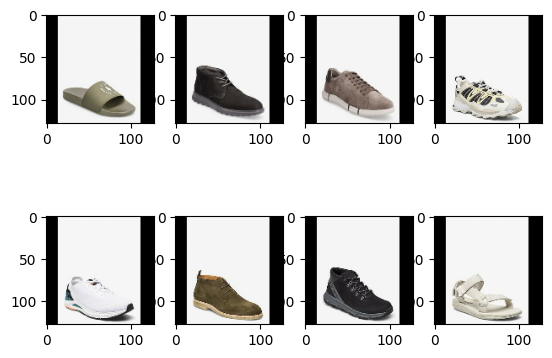

In [34]:
for images, labels in train_ds.take(1):
    for i, image in enumerate(images):
        plt.subplot(2, 4, i + 1)
        plt.imshow(image)

In [35]:
inputs = tf.keras.Input(shape=IMAGE_SIZE + (3,))

# resnet = tf.keras.applications.ResNet50(include_top=False, weights="imagenet")

# x = tf.keras.applications.resnet.preprocess_input(inputs)
# x = resnet(x)


x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding="same")(inputs)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="same")(x)
x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same")(x)
x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same")(x)
x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Flatten()(x)

outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_25 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 63, 63, 64)        18496     
                                                                 
 conv2d_27 (Conv2D)          (None, 61, 61, 64)        36928     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 30, 30, 64)       0         
 g2D)                                                      

In [36]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
        "accuracy",
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.AUC()
    ],
)

In [37]:
weight_for_0 = (1 / len(train_df.query("label == 0"))) * (len(train_df) / 2.0)
weight_for_1 = (1 / len(train_df.query("label == 1"))) * (len(train_df) / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}
class_weight

{0: 0.9479166666666666, 1: 1.0581395348837208}

In [38]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    # class_weight=class_weight
)

Epoch 1/30


2023-07-19 20:33:31.913495: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [273]
	 [[{{node Placeholder/_1}}]]
2023-07-19 20:33:31.914073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [273]
	 [[{{node Placeholder/_1}}]]


35/35 [==============================] - ETA: 0s - loss: 0.6964 - accuracy: 0.5458 - precision_2: 0.5714 - recall_2: 0.1550 - auc_2: 0.5085

2023-07-19 20:33:36.019851: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [31]
	 [[{{node Placeholder/_0}}]]
2023-07-19 20:33:36.020022: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [31]
	 [[{{node Placeholder/_1}}]]


35/35 [==============================] - 4s 98ms/step - loss: 0.6964 - accuracy: 0.5458 - precision_2: 0.5714 - recall_2: 0.1550 - auc_2: 0.5085 - val_loss: 0.6928 - val_accuracy: 0.5161 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_auc_2: 0.5000
Epoch 2/30
35/35 [==============================] - 3s 91ms/step - loss: 0.6932 - accuracy: 0.5055 - precision_2: 0.2500 - recall_2: 0.0233 - auc_2: 0.4654 - val_loss: 0.6930 - val_accuracy: 0.5161 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_auc_2: 0.5000
Epoch 3/30
35/35 [==============================] - 3s 91ms/step - loss: 0.6934 - accuracy: 0.5055 - precision_2: 0.4211 - recall_2: 0.1240 - auc_2: 0.5437 - val_loss: 0.6929 - val_accuracy: 0.5161 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - val_auc_2: 0.4375
Epoch 4/30
35/35 [==============================] - 3s 92ms/step - loss: 0.6911 - accuracy: 0.5458 - precision_2: 1.0000 - recall_2: 0.0388 - auc_2: 0.5510 - val_loss: 0.6928 - val_accur

In [39]:
model.evaluate(test_ds)

 7/10 [====================>.........] - ETA: 0s - loss: 0.8739 - accuracy: 0.7736 - precision_2: 0.7500 - recall_2: 0.8571 - auc_2: 0.8550

2023-07-19 20:35:15.147274: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [77]
	 [[{{node Placeholder/_1}}]]
2023-07-19 20:35:15.147807: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [77]
	 [[{{node Placeholder/_1}}]]


10/10 [==============================] - 0s 20ms/step - loss: 0.7784 - accuracy: 0.7922 - precision_2: 0.7561 - recall_2: 0.8378 - auc_2: 0.8736


[0.7783961296081543,
 0.7922077775001526,
 0.7560975551605225,
 0.837837815284729,
 0.8736486434936523]

2/2 [==============================] - 0s 31ms/step


2023-07-19 21:06:06.372055: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [77]
	 [[{{node Placeholder/_1}}]]


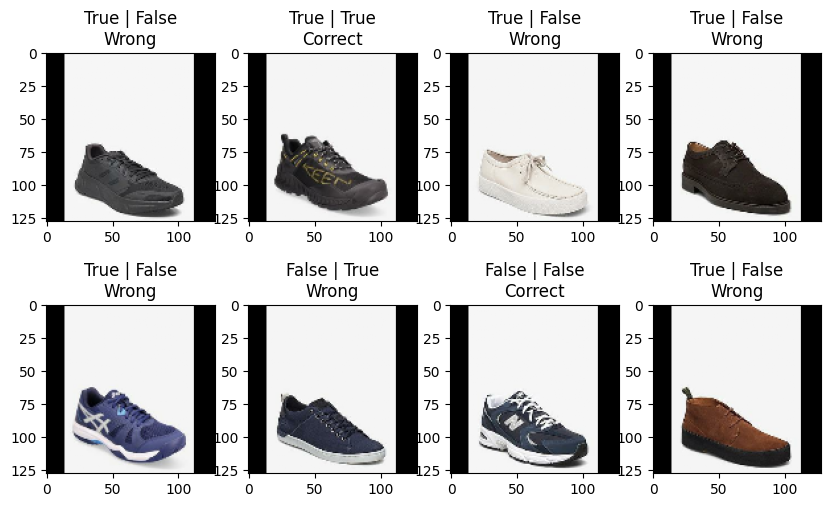

In [77]:
test = test_ds.take(1)

predictions = model.predict(test)

plt.figure(figsize=(10, 6))

for images, label in test:
    for i, image in enumerate(images):
        plt.subplot(2, 4, i + 1)
        plt.imshow(image)
        is_correct = "Wrong"
        if (predictions[i][0] > 0.5) == labels[i]:
            is_correct = "Correct"
        plt.title(f"{predictions[i][0] > 0.5} | {labels[i] == 1}\n{is_correct}")